In [1]:
!pip list

Package                      Version             
---------------------------- --------------------
absl-py                      1.2.0               
argon2-cffi                  21.3.0              
argon2-cffi-bindings         21.2.0              
asttokens                    2.0.8               
astunparse                   1.6.3               
attrs                        22.1.0              
backcall                     0.2.0               
beautifulsoup4               4.11.1              
bleach                       5.0.1               
cachetools                   5.2.0               
certifi                      2019.11.28          
cffi                         1.15.1              
chardet                      3.0.4               
cycler                       0.11.0              
dbus-python                  1.2.16              
debugpy                      1.6.3               
decorator                    5.1.1               
defusedxml                   0.7.1               


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf


In [3]:
csvfileD = open("Dataset.csv", "r")
dataset = pd.read_csv(csvfileD)

In [4]:
x_1 = dataset['x1']
x_2 = dataset['x2']
y = dataset['y']

x_1 = x_1.values
x_2 = x_2.values
y = y.values
# x1 and x2 are the independent variables and y is the dependent variable

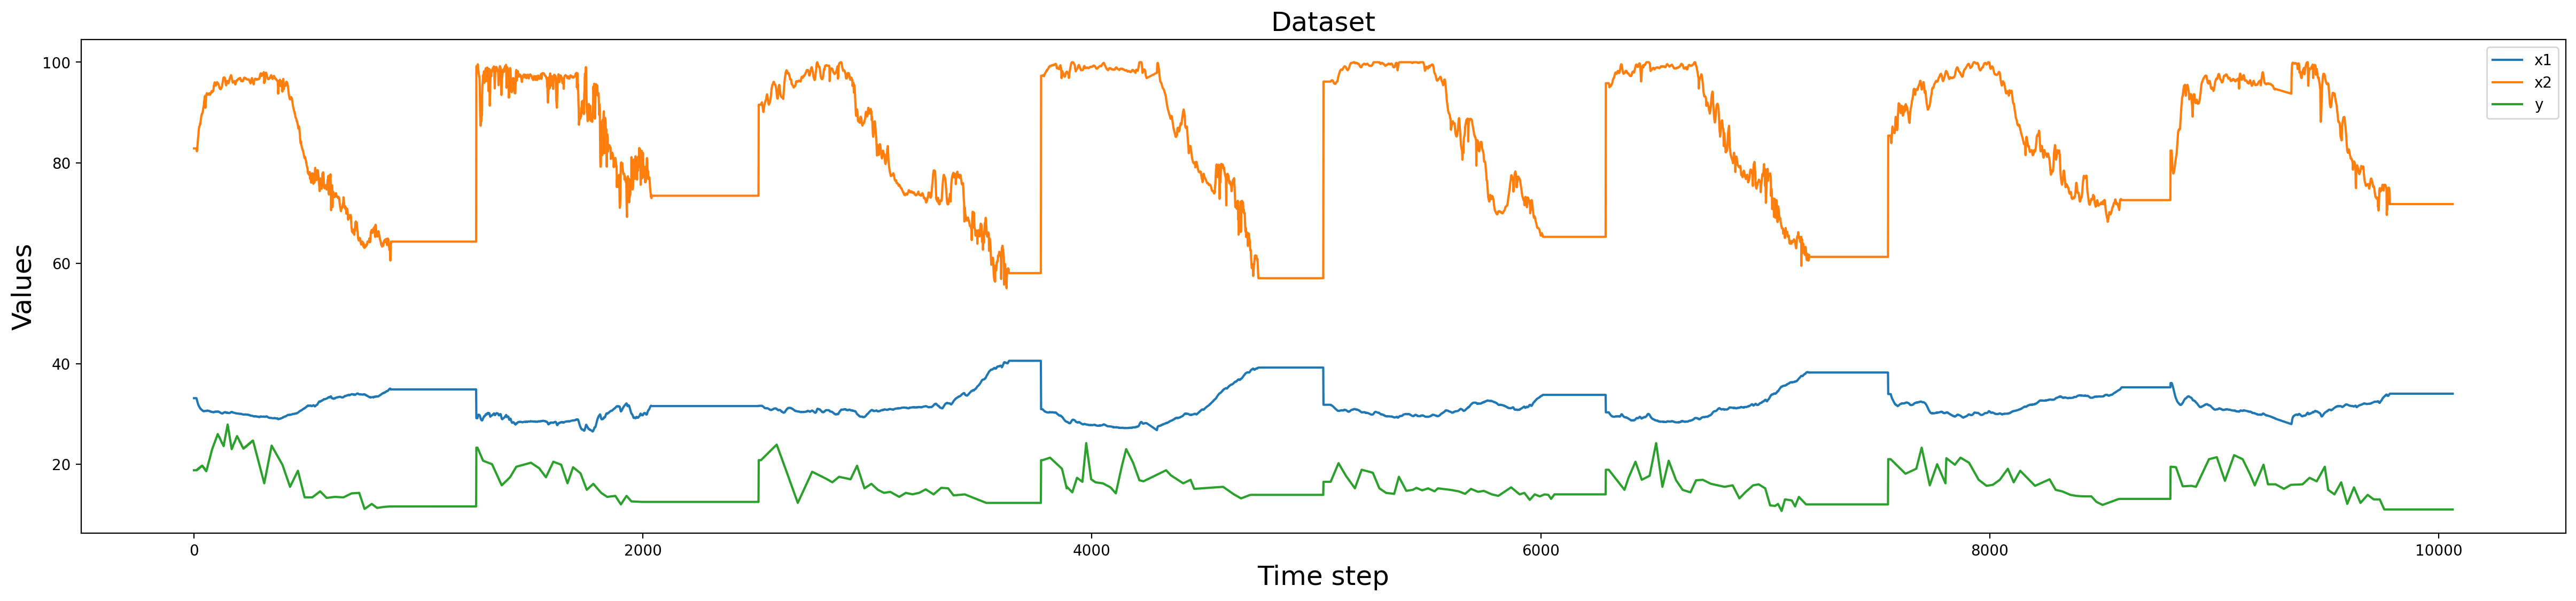

In [5]:
plt.figure(figsize=(30, 6))
plt.plot(x_1[:10064] , label='x1')
plt.plot(x_2[:10064] , label='x2')
plt.plot(y[:10064] , label='y')
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

In [6]:
# convert to [rows, columns] structure
x_1 = x_1.reshape((len(x_1), 1))
x_2 = x_2.reshape((len(x_2), 1))
y = y.reshape((len(y), 1))

print ("x_1.shape" , x_1.shape)
print ("x_2.shape" , x_2.shape)
print ("y.shape" , y.shape)

x_1.shape (35224, 1)
x_2.shape (35224, 1)
y.shape (35224, 1)


In [7]:
# normalization features
scaler = MinMaxScaler(feature_range=(0, 1))
x_1_scaled = scaler.fit_transform(x_1)
x_2_scaled = scaler.fit_transform(x_2)
y_scaled = scaler.fit_transform(y)

# horizontally stack columns
dataset_stacked = hstack((x_1_scaled, x_2_scaled, y_scaled))

print ("dataset_stacked.shape" , dataset_stacked.shape)

dataset_stacked.shape (35224, 3)


In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


In [9]:
# choose a number of time steps and change this accordingly
n_steps_in, n_steps_out = 60 , 30    
# The returned arrays are arranged in [n_dataset, n_steps_in , n_features] and [n_dataset, n_steps_out]
# ******* input ******* There are 2 key arguments we need to specify which are :
# 1. n_steps_in : Specify how much data we want to look back for prediction
# 2. n_step_out : Specify how much multi-step data we want to forecast
# example: STEPS_IN = 60  and STEPS_OUT = 30 
# lookback on 60 (x1,x2) past data, to forecast future 30 multi-step ahead of data
# Therefore\, the returned X and y are time-step shifted according to the argument, the the size should be (35139, 60, 2) and (35139, 30)
# 

# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)

print ("X.shape" , X.shape)
print ("y.shape" , y.shape)

X.shape (35136, 60, 2)
y.shape (35136, 30)


In [10]:
# we have a total of 28 batches of dependent and independent variables
# ******* input ******* now is the time to split them into 25 batches for training and the rest 3 batches for testing

split = 1258*25
train_X , train_y = X[:split, :] , y[:split, :]
test_X , test_y = X[split:, :] , y[split:, :]

n_features = train_X.shape[2]


In [11]:
print ("train_X.shape" , train_X.shape)   # [n_datasets,n_steps_in,n_features]
print ("train_y.shape" , train_y.shape)   # [n_datasets,n_steps_out]
print ("test_X.shape" , test_X.shape)
print ("test_y.shape" , test_y.shape)
print ("n_features" , n_features)

train_X.shape (31450, 60, 2)
train_y.shape (31450, 30)
test_X.shape (3686, 60, 2)
test_y.shape (3686, 30)
n_features 2


**LSTM Model Parameter Setting**

In [12]:
# LSTM Model Setting
# The input_shape of the first LSTM node specify the shape of input data for prediction in the evaluation phase
# Meanwhile, the Dense Layer specify the output shape of the model based on n_steps_out
# ******* input ******* architecture may also vary

#optimizer learning rate
opt = keras.optimizers.Adam(learning_rate=0.01)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=['mse'])


In [13]:
# Training
# We have 25 batches of dataset, therefore the steps_per_epoch will be 25. In each steps, it will take 1258 data points (1 batch) for training
# With 25 steps per epoch, all 25 batches will be trained in each epoch
# With 60 epochs, each batch will be trained 60 times
# ******* input ******** parameters may vary

# Fit network
history = model.fit(train_X , train_y , epochs=60 , steps_per_epoch=25 , verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False)


Epoch 1/60
25/25 [==============================] - 4s 116ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 2/60
25/25 [==============================] - 2s 99ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 3/60
25/25 [==============================] - 3s 104ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 4/60
25/25 [==============================] - 3s 103ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 5/60
25/25 [==============================] - 3s 105ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 6/60
25/25 [==============================] - 3s 103ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 7/60
25/25 [==============================] - 3s 102ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 8/60
25/25 [==============================] - 3s 105ms/step - loss: 0.0

Evaluation



In [14]:
# Test Data Batch 1 , Test Data Batch 2 , Test Data Batch 3
# reading the first batch of test data, and reshape and scale it  
csvfileb1 = open("Test Data Batch 1.csv", "r")
dataset_test_ok = pd.read_csv(csvfileb1)

In [15]:

dataset_test_ok.head()

,y,x1,x2
0,22.2,33.50,72.41
1,22.2,33.61,75.22
2,22.2,33.78,79.00
3,22.2,33.91,75.72
4,22.2,34.02,67.09


In [16]:
# read test data
x1_test = dataset_test_ok['x1'].values
x2_test = dataset_test_ok['x2'].values
y_test = dataset_test_ok['y'].values # no need to scale

# convert to [rows, columns] structure
x1_test = x1_test.reshape((len(x1_test), 1))
x2_test = x2_test.reshape((len(x2_test), 1))
y_test = y_test.reshape((len(y_test), 1))

x1_test_scaled = scaler.fit_transform(x1_test)
x2_test_scaled = scaler.fit_transform(x2_test)


In [17]:
# PERFORMANCE EVALUATION
# prep_data: function to prepare test data and feed into our trained model to forecast the next n_step_out  (30) data, and
# prepare the past data for plotting purposes as well as groundtruth for validation
#
# start , end : To specify range of Test Data based on n_steps_in. can be any point in the test data batch
# last : last data of predicted value based on n_step_out
#
# ********* prep_data inputs: x1_test_scaled, x2_test_scaled, y_test and specify the start argument
# The end & last will be calculated automatically !
#


def prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last):
    #prepare test data X
    dataset_test = hstack((x1_test_scaled, x2_test_scaled))
    dataset_test_X = dataset_test[start:end, :]
    test_X_new = dataset_test_X.reshape(1, dataset_test_X.shape[0] , dataset_test_X.shape[1])

    #prepare past and groundtruth
    past_data = y_test[:end , :]
    dataset_test_y = y_test[end:last , :]
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    scaler1.fit(dataset_test_y)

    # predictions
    y_pred = model.predict(test_X_new)
    y_pred_inv = scaler1.inverse_transform(y_pred)
    y_pred_inv = y_pred_inv.reshape(n_steps_out,1)
    y_pred_inv = y_pred_inv[:,0]

    return y_pred_inv , dataset_test_y , past_data

# Calculate MAE and RMSE
# feed in the forecasted results and groundtruth 
def evaluate_prediction(predictions, actual, model_name , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('')
    print('')

# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):

    plt.figure(figsize=(20, 4))

    y_mean = mean(prediction1)

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')

    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

In [18]:
# Plot history and future (this looks repeated from above???)
def plot_multistep(history, prediction1 , groundtruth , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = mean(prediction1)
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')
    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

1/1 [==============================] - 0s 189ms/step
Test Data from 120 to 180
Mean Absolute Error: 0.42
Root Mean Square Error: 0.46


1/1 [==============================] - 0s 21ms/step
Test Data from 180 to 240
Mean Absolute Error: 0.23
Root Mean Square Error: 0.27




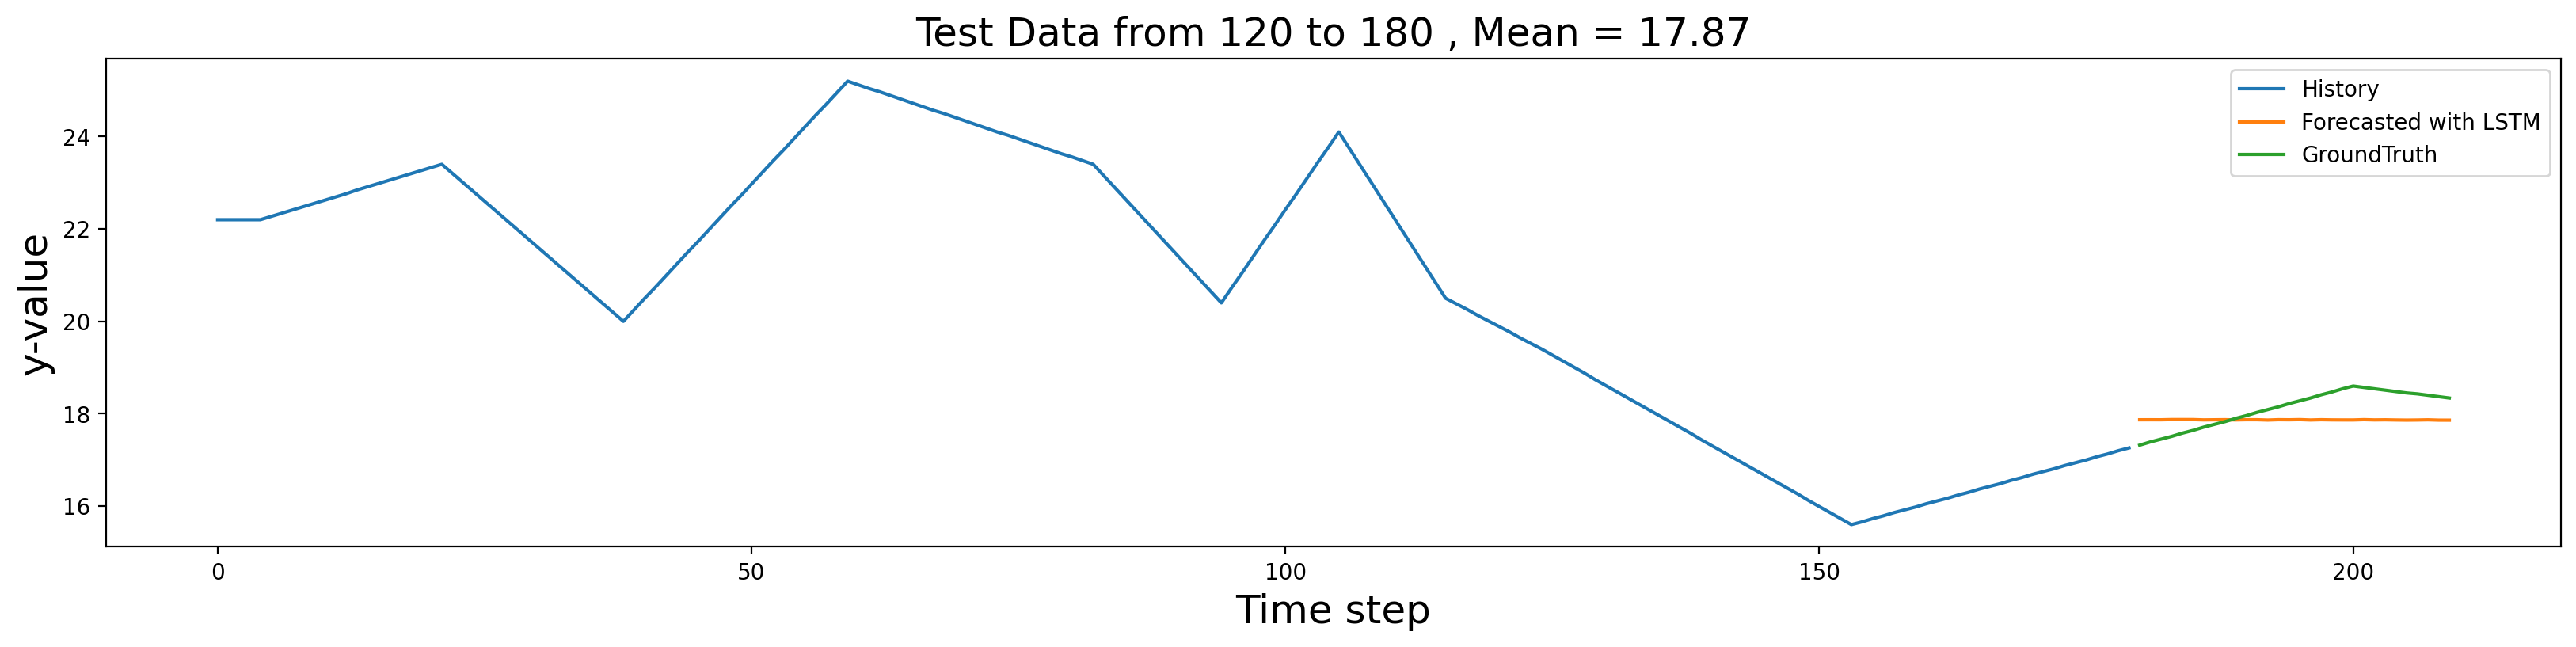

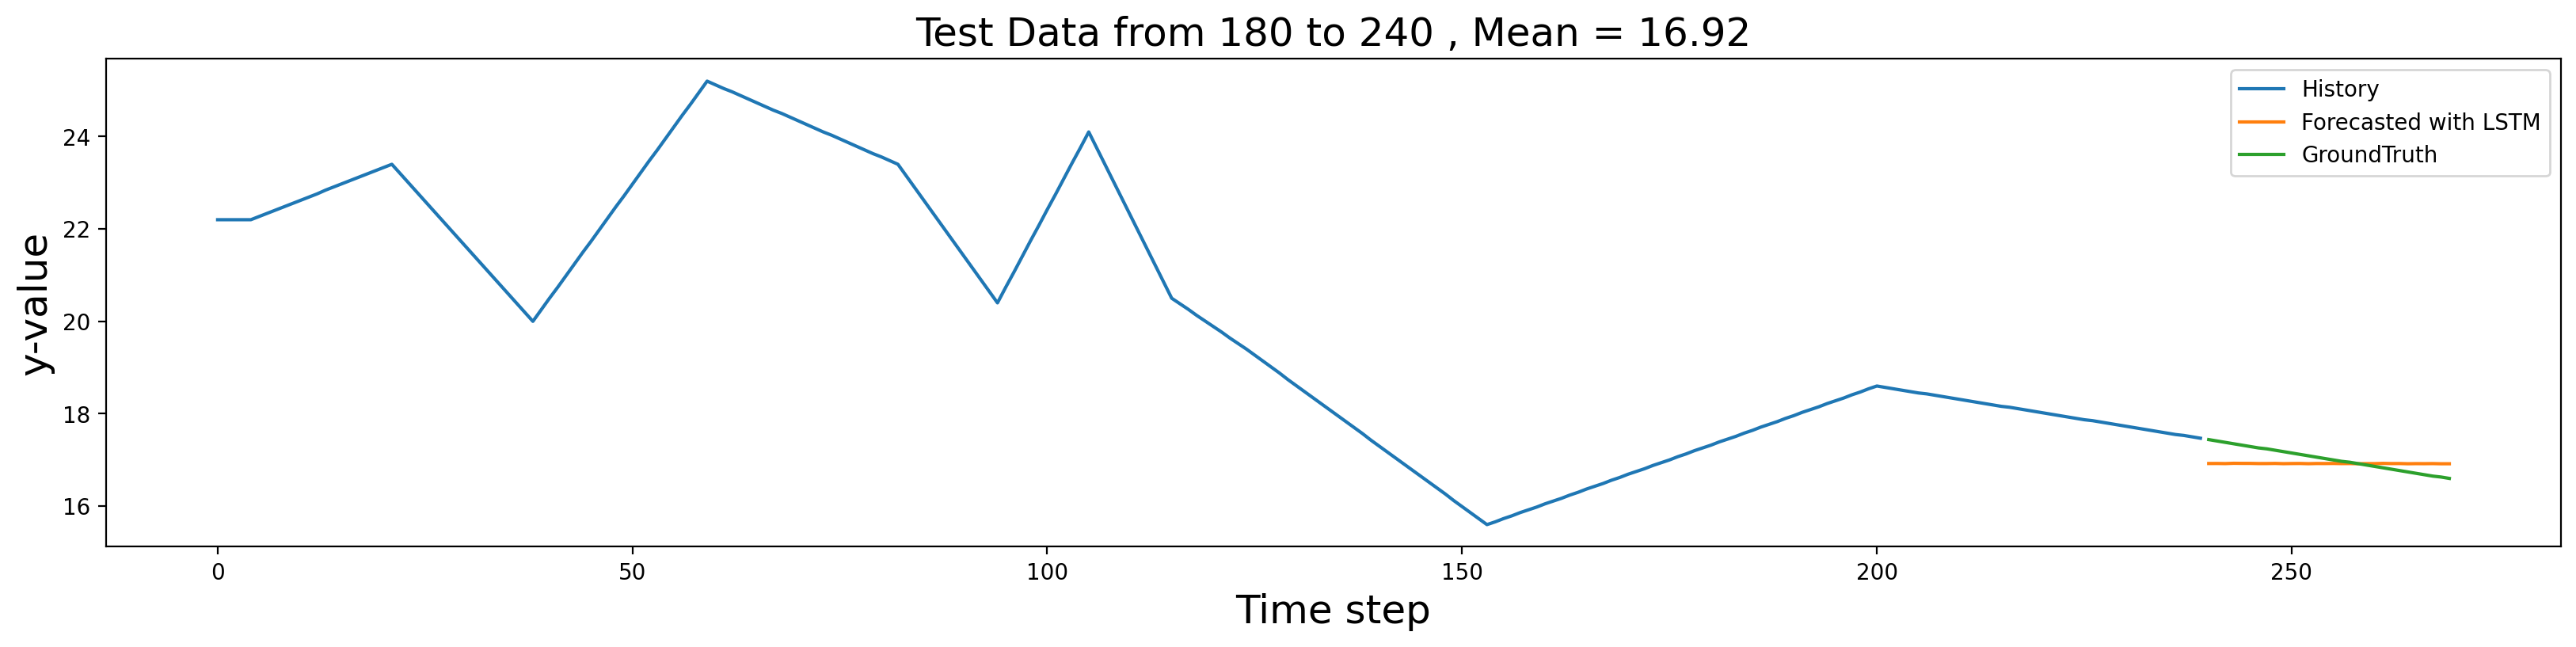

In [19]:
# For the first batch of test data (the only one being considered here)
# 120 to 180 and 180 to 240 will be the testing data to be fed into the trained model
# to forecast 30 steps ahead data based on previous 60 data with 2 features
# (for the case where n_steps_in = 60 and n_steps_out = 30)
# ******** This code is also capable of processing datasets with more than 2 features

for i in range(120,240,60):
    start = i
    end = start + n_steps_in
    last = end + n_steps_out
    y_pred_inv , dataset_test_y , past_data = prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last)
    evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , start , end)
    plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end)


Save & Load


In [ ]:
# model_url = '/Directory/Filename.h5'
# model.save(model_url)
# print("Saved")

In [ ]:
# model_url = '/Directory/Filename.h5'
# model = load_model(model_url)
# print("Loaded")
# model.summary()